In [1]:
using Pkg
Pkg.activate("/mnt/dv/wid/projects4/SolisLemus-network-merging/")

using InPhyNet, PhyloNetworks
base_dir = "/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/"
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/helpers.jl")
include("/mnt/dv/wid/projects4/SolisLemus-network-merging/simulation-study/simulation-scripts/helpers/est_constraints-helpers.jl")

  Activating project at `/mnt/dv/wid/projects4/SolisLemus-network-merging`


log_runtime (generic function with 1 method)

#### Load and Examine Data

In [2]:
est_gts = readMultiTopology(joinpath(base_dir, "data", "Best.FAA.tre"))
length(est_gts)

410

*Lots* of spread in the estimated gene trees on who is included

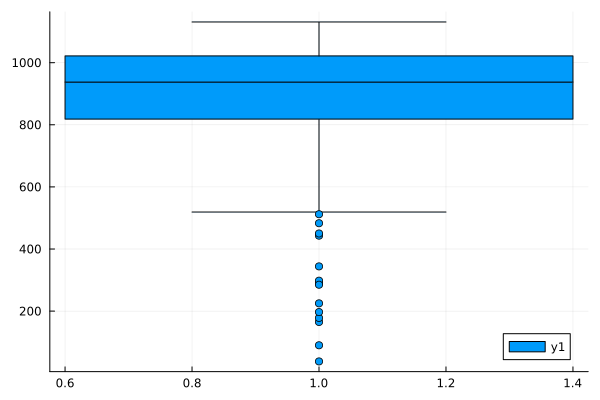

In [56]:
return

using Plots, StatsPlots
ntaxas = [t.numTaxa for t in est_gts]
println("min: $(minimum(ntaxas)), max: $(maximum(ntaxas))")
uq_names = Set()
for t in est_gts
    union!(uq_names, [l.name for l in t.leaf])
end
println("total unique names: $(length(uq_names))")

boxplot(ntaxas)

In [57]:
return

name_vec = Vector(collect(keys(uq_names.dict)))
name_map = Dict([name_vec[i] => i for i=1:length(uq_names)])
counts = zeros(length(uq_names))
for gt in est_gts
    for leaf in gt.leaf
        counts[name_map[leaf.name]] += 1
    end
end
minimum(counts), maximum(counts)

(75.0, 398.0)

## Subset decomposition

In [3]:
est_D, est_namelist = calculateAGIC(est_gts)

([0.0 23.362962962962964 … 19.582278481012658 20.869109947643977; 23.362962962962964 0.0 … 35.43092105263158 36.61423220973783; … ; 19.582278481012658 35.43092105263158 … 0.0 10.524663677130045; 20.869109947643977 36.61423220973783 … 10.524663677130045 0.0], ["AALA", "AAXJ", "ABCD", "ABEH", "ABIJ", "ABSS", "ACFP", "ACRY", "ACWS", "ADHK"  …  "ZSSR", "ZTHV", "ZTLR", "ZUHO", "ZULJ", "ZXJO", "ZYAX", "ZYCD", "ZZEI", "ZZOL"])

In [4]:
best_tree = readTopology("data/estimated_species_tree.tree")
subsets = sateIdecomp(best_tree, 25)
println(sort([length(s) for s in subsets])[1:5])
println(maximum([length(s) for s in subsets]))
println(length(subsets))

[10, 11, 11, 11, 11]
25
69


## Generate Condor data

Outline:

We use stopping rules to decide the number of retics in each subnet, so
1. if no snaq file exists yet, submit runs w/ h=0,1
2. if snaq files exist, load last 2 runs and check if another should be submitted with the function `should_stop_AIC`

This code should build the submit file's tables from scratch each time so that runs are never re-submitted.

In [40]:
df_dir = "data/CFs/"
init_dir = "data/init_trees/"
out_dir = "data/snaq_outputs/"
tab_file = "condor/inputs.tab"

open(tab_file, "a+") do tab_io
    # For now just queue all of them with h=0, 1, 2 b/c it's easier...
    for (i, subset_taxa) in enumerate(subsets)
        print("\r$(i)/$(length(subsets))")
        flush(stdout)

        temp_gts = Array{HybridNetwork}(undef, length(est_gts))
        for i = 1:length(est_gts)
            if length(intersect([l.name for l in est_gts[i].leaf], subset_taxa)) >= 4
                temp_gts[i] = pruneTruthFromDecomp(est_gts[i], subset_taxa)
            end
        end
        temp_gts = temp_gts[findall(i -> isassigned(temp_gts, i), 1:length(temp_gts))]

        # 1. count quartets
        q, t = silently() do
            countquartetsintrees([t for t in temp_gts if length(t.leaf) >= 4])
        end
        df = silently() do
            readTableCF(writeTableCF(q, t))
        end
        CSV.write(joinpath(df_dir, "df_$(i).csv"), writeTableCF(df))

        # 2. save starting tree
        init_tree = pruneTruthFromDecomp(best_tree, subset_taxa)
        writeTopology(init_tree, joinpath(init_dir, "init_$(i).tre"))

        # 3. Write info to Condor input table
        write(tab_io, "$(i),0\n")
        write(tab_io, "$(i),1\n")
        write(tab_io, "$(i),2\n")
        write(tab_io, "$(i),3\n")
        write(tab_io, "$(i),4\n")
    end
end

69/69

## Infer constraints

This is done in Condor with the submit file `empirical-study/condor/submit.submit`

## InPhyNet

In [6]:
df = readTableCF("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/CFs/df_1.csv")
tre0 = readTopology("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/init_trees/init_1.tre")
tre = readTopology("/mnt/dv/wid/projects4/SolisLemus-network-merging/empirical-study/data/Best.FAA.tre")

between 43.0 and 331.0 gene trees per 4-taxon set


HybridNetwork, Rooted Network
1953 edges
1954 nodes: 978 tips, 0 hybrid nodes, 976 internal tree nodes.
tip labels: TVSH, KEGA, SUAK, JTQQ, ...
((TVSH:0.048,KEGA:0.024)90:0.017,(SUAK:0.044,((JTQQ:0.039,(VLNB:0.066,(SLYR:0.027,(ZSSR:0.037,(CMFF:0.089,(((JETM:0.063,RKFX:0.03)87:0.028,RKLL:0.107)42:0.011,((((UDUT:0.186,KVAY:0.118)22:0.047,(((RBYC:0.195,(IANR:0.08,((SQCF:0.025,XFFT:0.003)79:0.041,(Prupe_v1.0:0.051,(EAVM:0.013,VCIN:0.011)98:0.033)91:0.015)55:0.011)78:0.042)28:0.018,((WVEF:0.043,EILE:0.024)95:0.108,((WKCY:0.137,(EDHN:0.042,XVJB:0.026)83:0.014)54:0.021,(KYAD:0.047,(BJSW:0.04,AQGE:0.019)97:0.053)99:0.065)50:0.009)55:0.032)26:0.021,((((((((PKMO:0.144,WMUK:0.048)69:0.033,KPTE:0.072)29:0.018,ATFX:0.13)16:0.009,((Theca_v1.1:0.081,OLXF:0.074)42:0.01,(OCTM:0.235,(PUDI:0.093,AWJM:0.018)100:0.073)13:0.065)4:0.007)2:0.026,((XMQO:0.121,((LNER:0.106,LWDA:0.047)17:0.023,(((SVVG:0.048,(YZVJ:0.082,(HENI:0.02,(UZWG:0.007,NHUA:0.006)71:0.007)81:0.015)40:0.034)21:0.022,INSP:0.007)7:0.012,TJLC:

In [7]:
est_constraints = Array{Union{Int64, HybridNetwork}}(undef, length(subsets), 3)
negloglik = zeros(Float64, length(subsets), 3) .- 1.0
est_constraints .= 0

for subset_idx = 1:length(subsets)
    for h = 0:2
        if isfile("data/snaq_data/snaq_$(subset_idx)_h$(h).out")
            net_string = readlines("data/snaq_data/snaq_$(subset_idx)_h$(h).out")[1]
            negloglik[subset_idx, h+1] = parse(Float64, split(net_string, " -Ploglik = ")[2])
            net_string = split(net_string, " -Ploglik")[1]
            est_constraints[subset_idx, h+1] = readTopology(net_string)
        end
    end
end

sum(negloglik .!= -1), length(subsets) * 3

(196, 207)

In [8]:
negloglik

69×3 Matrix{Float64}:
 12099.9       -1.0      -1.0
 15879.5       -1.0      -1.0
  3858.68    3552.81   3438.48
 13902.0    13458.1      -1.0
 10465.0     8527.76   8516.57
  2064.51    1736.75   1693.66
  4809.91    3613.67   3604.33
   634.139    533.292   501.588
  1780.93    1365.13   1325.97
  1532.16    1141.6    1038.71
     ⋮                 
  2364.64    2117.66   2073.5
   676.79     507.002   413.269
   692.29     478.7     432.995
   371.557    244.279   240.175
   567.351    448.068   384.303
   371.557    184.118   183.709
   951.978    800.172   780.061
   392.803    287.706   283.796
  2257.56    1249.78   1096.72

In [38]:
aa = negloglik[:,1] .- negloglik[:,2]
mm = maximum(aa[negloglik[:,2] .!= -1.0])
findfirst(aa .== mm)

22

In [39]:
negloglik[22,:]

3-element Vector{Float64}:
 16397.233376936834
 13903.213221359472
  9284.985599241993